In [10]:

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path
import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 5,0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

AttributeError: module 'tensorflow_core._api.v2.config' has no attribute 'list_physical_devices'

# RNN
![](images/1.png)

![](images/7.png)
![](images/8.png)


## RNN 의 여러 구조들
![](images/2.png)


In [ ]:
# From scratch

class RNN:
    def __init__(self, input_size, output_size, hidden_size):
        # hidden to hidden
        self.Whh = randn(hidden_size, hidden_size)
        # input to hidden
        self.Wxh = randn(hidden_size, input_size)
        # hidden to output
        self.Why = randn(output__size, hidden_size)
        self.bh = zeros((hidden_size, 1))
        self.by = zeros((output_size, 1))
    
    def forward(self, inputs):
        h = zeros(self.Whh.shape[0], 1)
        
        # hidden step
        for i, x in enumerate(inputs):
            h = tanh(self.Wxh @ x + self.Whh @ h + self.bh)
        
        # output
        y = self.Why @ h + self.by
        return y, h

In [2]:
# 데이터 생성
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [12]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [13]:
print(X_train.shape)
print(y_train.shape)

(7000, 50, 1)
(7000, 1)


Saving figure time_series_plot


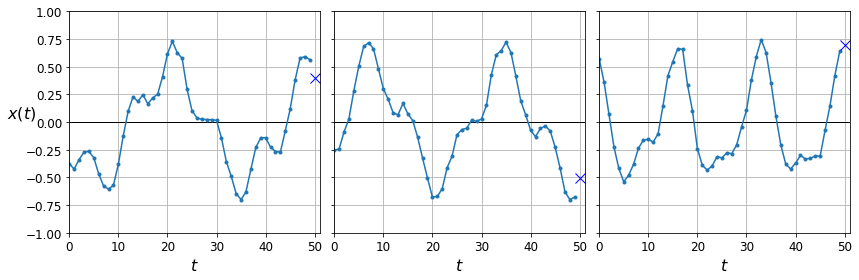

In [5]:
# 다변량 시계열
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()

In [6]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Epoch 1/5
219/219 [==============================] - 4s 19ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/5
219/219 [==============================] - 4s 18ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/5
219/219 [==============================] - 4s 18ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/5
219/219 [==============================] - 4s 18ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/5
219/219 [==============================] - 4s 18ms/step - loss: 0.0166 - val_loss: 0.0151


In [7]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0149


0.01486349105834961

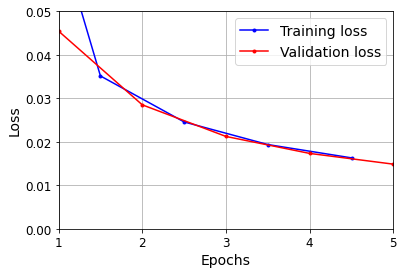

In [16]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [19]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Epoch 1/5
219/219 [==============================] - 11s 52ms/step - loss: 0.0137 - val_loss: 0.0041
Epoch 2/5
219/219 [==============================] - 11s 51ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 3/5
219/219 [==============================] - 11s 51ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 4/5
219/219 [==============================] - 11s 51ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 5/5
219/219 [==============================] - 11s 51ms/step - loss: 0.0031 - val_loss: 0.0029


In [20]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 12ms/step - loss: 0.0029


0.002876753220334649

In [22]:
# 개선
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))

Epoch 1/5
219/219 [==============================] - 8s 37ms/step - loss: 0.0530 - val_loss: 0.0082
Epoch 2/5
219/219 [==============================] - 8s 36ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 3/5
219/219 [==============================] - 8s 35ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 4/5
219/219 [==============================] - 8s 35ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 5/5
219/219 [==============================] - 8s 36ms/step - loss: 0.0034 - val_loss: 0.0035


In [30]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

Saving figure forecast_ahead_plot


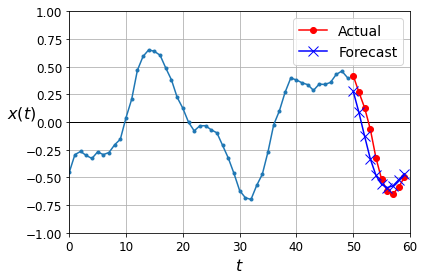

In [31]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

In [34]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [35]:
print(X_train.shape)
print(Y_train.shape)

(7000, 50, 1)
(7000, 10)


In [37]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Epoch 1/5
219/219 [==============================] - 8s 36ms/step - loss: 0.0691 - val_loss: 0.0328
Epoch 2/5
219/219 [==============================] - 8s 36ms/step - loss: 0.0265 - val_loss: 0.0197
Epoch 3/5
219/219 [==============================] - 8s 36ms/step - loss: 0.0191 - val_loss: 0.0191
Epoch 4/5
219/219 [==============================] - 8s 36ms/step - loss: 0.0174 - val_loss: 0.0155
Epoch 5/5
219/219 [==============================] - 8s 36ms/step - loss: 0.0150 - val_loss: 0.0133


![](images/3.png)

In [39]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 8ms/step - loss: 0.0141


0.014088193885982037

In [3]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [4]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [9]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Epoch 1/5
219/219 [==============================] - 8s 37ms/step - loss: 0.0544 - last_time_step_mse: 0.0446 - val_loss: 0.0430 - val_last_time_step_mse: 0.0311
Epoch 2/5
219/219 [==============================] - 8s 36ms/step - loss: 0.0403 - last_time_step_mse: 0.0286 - val_loss: 0.0357 - val_last_time_step_mse: 0.0238
Epoch 3/5
219/219 [==============================] - 8s 37ms/step - loss: 0.0346 - last_time_step_mse: 0.0223 - val_loss: 0.0330 - val_last_time_step_mse: 0.0189
Epoch 4/5
219/219 [==============================] - 8s 37ms/step - loss: 0.0324 - last_time_step_mse: 0.0207 - val_loss: 0.0296 - val_last_time_step_mse: 0.0164
Epoch 5/5
219/219 [==============================] - 8s 36ms/step - loss: 0.0294 - last_time_step_mse: 0.0175 - val_loss: 0.0268 - val_last_time_step_mse: 0.0138


In [10]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0268 - last_time_step_mse: 0.0138


[0.02678973786532879, 0.013825667090713978]

# LSTM
![](images/9.png)

In [24]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

```python
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
```
해줘야 돌아감

In [7]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Epoch 1/5
219/219 [==============================] - 2s 9ms/step - loss: 0.0774 - last_time_step_mse: 0.0634 - val_loss: 0.0538 - val_last_time_step_mse: 0.0362
Epoch 2/5
219/219 [==============================] - 2s 8ms/step - loss: 0.0461 - last_time_step_mse: 0.0241 - val_loss: 0.0400 - val_last_time_step_mse: 0.0173
Epoch 3/5
219/219 [==============================] - 2s 8ms/step - loss: 0.0373 - last_time_step_mse: 0.0155 - val_loss: 0.0350 - val_last_time_step_mse: 0.0146
Epoch 4/5
219/219 [==============================] - 2s 8ms/step - loss: 0.0336 - last_time_step_mse: 0.0134 - val_loss: 0.0322 - val_last_time_step_mse: 0.0131
Epoch 5/5
219/219 [==============================] - 2s 8ms/step - loss: 0.0315 - last_time_step_mse: 0.0125 - val_loss: 0.0307 - val_last_time_step_mse: 0.0125


In [8]:

model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0307 - last_time_step_mse: 0.0125


[0.03068448230624199, 0.012477453798055649]

keras.layers.LSTMCell <<< keras.layers.LSTM(GPU에서 더 최적화된 구현)

# GRU

(lstm의 간소화 버전

![](images/5.png)

In [18]:
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Epoch 1/5
219/219 [==============================] - 2s 9ms/step - loss: 0.1462 - last_time_step_mse: 0.1447 - val_loss: 0.1460 - val_last_time_step_mse: 0.1442
Epoch 2/5
219/219 [==============================] - 2s 7ms/step - loss: 0.1461 - last_time_step_mse: 0.1447 - val_loss: 0.1460 - val_last_time_step_mse: 0.1443
Epoch 3/5
219/219 [==============================] - 2s 7ms/step - loss: 0.1461 - last_time_step_mse: 0.1447 - val_loss: 0.1460 - val_last_time_step_mse: 0.1441
Epoch 4/5
219/219 [==============================] - 2s 7ms/step - loss: 0.1461 - last_time_step_mse: 0.1447 - val_loss: 0.1459 - val_last_time_step_mse: 0.1443
Epoch 5/5
219/219 [==============================] - 2s 8ms/step - loss: 0.1461 - last_time_step_mse: 0.1447 - val_loss: 0.1459 - val_last_time_step_mse: 0.1442


In [16]:
y_train.shape

(7000, 1)

# 1D Conv layer


1D conv layer with kernel size 4, stride 2, VALID padding:

             |-----2-----|     |-----5---...------|     |-----23----|
         |-----1-----|     |-----4-----|   ...      |-----22----|
     |-----0----|      |-----3-----|     |---...|-----21----|
  
    X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49

    Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50

      /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

    Output:

    X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49

    Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
    
1D Conv이 매우 짧은 하나의 순차 패턴을 감지

In [25]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=5,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/5
219/219 [==============================] - 2s 7ms/step - loss: 0.0693 - last_time_step_mse: 0.0631 - val_loss: 0.0447 - val_last_time_step_mse: 0.0367
Epoch 2/5
219/219 [==============================] - 1s 6ms/step - loss: 0.0401 - last_time_step_mse: 0.0324 - val_loss: 0.0346 - val_last_time_step_mse: 0.0264
Epoch 3/5
219/219 [==============================] - 1s 6ms/step - loss: 0.0327 - last_time_step_mse: 0.0244 - val_loss: 0.0294 - val_last_time_step_mse: 0.0198
Epoch 4/5
219/219 [==============================] - 1s 6ms/step - loss: 0.0281 - last_time_step_mse: 0.0183 - val_loss: 0.0258 - val_last_time_step_mse: 0.0151
Epoch 5/5
219/219 [==============================] - 1s 6ms/step - loss: 0.0252 - last_time_step_mse: 0.0146 - val_loss: 0.0239 - val_last_time_step_mse: 0.0135


# WAVENET

하위층은 단기 패턴 학습, 상위 층은 장기 패턴 학습

![](images/6.png)

In [28]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, None, 20)          60        
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_17 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, None, 20)        

In [29]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=5,
                    validation_data=(X_valid, Y_valid))

Epoch 1/5
219/219 [==============================] - 1s 6ms/step - loss: 0.0670 - last_time_step_mse: 0.0560 - val_loss: 0.0338 - val_last_time_step_mse: 0.0217
Epoch 2/5
219/219 [==============================] - 1s 5ms/step - loss: 0.0309 - last_time_step_mse: 0.0183 - val_loss: 0.0282 - val_last_time_step_mse: 0.0166
Epoch 3/5
219/219 [==============================] - 1s 5ms/step - loss: 0.0276 - last_time_step_mse: 0.0152 - val_loss: 0.0263 - val_last_time_step_mse: 0.0147
Epoch 4/5
219/219 [==============================] - 1s 5ms/step - loss: 0.0259 - last_time_step_mse: 0.0138 - val_loss: 0.0260 - val_last_time_step_mse: 0.0145
Epoch 5/5
219/219 [==============================] - 1s 5ms/step - loss: 0.0250 - last_time_step_mse: 0.0130 - val_loss: 0.0243 - val_last_time_step_mse: 0.0126
